In [ ]:
# Note: You can select between running the Notebook on "CPU" or "GPU"
# Click "Runtime > Change Runtime time" and set "GPU"

In [ ]:
#Uncomment to install ydata-synthetic lib
#! pip install ydata-synthetic

# Time Series synthetic data generation with TimeGAN

- TimeGAN - Implemented accordingly with the [paper](https://papers.nips.cc/paper/8789-time-series-generative-adversarial-networks)
- This notebook is an example of how TimeGan can be used to generate synthetic time-series data.
- https://chowdera.com/2021/09/20210924011847878V.html
- https://curiousily.com/posts/time-series-anomaly-detection-using-lstm-autoencoder-with-pytorch-in-python/

## Dataset and imports

- The data used in this notebook was downloaded from [Yahoo finance](https://finance.yahoo.com/quote/GOOG/history?p=GOOG) and includes:
    - **6 variables** - Open, High, Low, Close, Adj Close, Volume
    - **1022 events** registered between the period of 1 January 2017 - 24 January 2021.
    - The data was processed using a MinMaxScaler (all the variables were numeric)

In [2]:
#Importing the required libs for the exercise

from os import path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append("/Users/aya/GIT/ydata-synthetic/src")
sys.path.append("/Users/aya/GIT/ydata-synthetic/src/ydata_synthetic")
sys.path.append("/Users/aya/GIT/ydata-synthetic/src/ydata_synthetic/synthesizers")
sys.path.append("/Users/aya/GIT/ydata-synthetic/src/ydata_synthetic/preprocessing/timeseries")
sys.path.append("/Users/aya/GIT/ydata-synthetic/src/ydata_synthetic/synthesizers.timeseries")


from ydata_synthetic.synthesizers import ModelParameters
from ydata_synthetic.preprocessing.timeseries import processed_stock
from ydata_synthetic.synthesizers.timeseries import TimeGAN

## Define Model hyperparameters

**Networks:**
- Generator
- Discriminator
- Embedder
- Recovery Network

TimeGAN is a Generative model based on RNN networks. In this package the implemented version follows a very simple architecture that is shared by the four elements of the GAN.

Similarly to other parameters, the architectures of each element should be optimized and tailored to the data.

In [3]:
#Specific to TimeGANs

seq_len = 32        # Timesteps
n_seq = 8          # Features

hidden_dim = 24     # Hidden units for generator (GRU & LSTM).
                    # Also decides output_units for generator

gamma = 1           # Used for discriminator loss

noise_dim = 32      # Used by generator as a starter dimension
dim = 128           # UNUSED
batch_size = 128
log_step = 100

learning_rate = 5e-4



gan_args = ModelParameters(batch_size=batch_size,
                           lr=learning_rate,
                           noise_dim=noise_dim,
                           layers_dim=dim)

## The data

In [4]:
stock_data,scaler = processed_stock(path='../../data/CitiesOsEnergyAndTemperature.csv', seq_len=seq_len)
#stock_data = processed_stock(path='../../data/stock_data.csv', seq_len=seq_len)
print(len(stock_data),stock_data[0].shape)

2353 (32, 8)


## Training the TimeGAN synthetizer

In [5]:
if path.exists('CitiesOS.pkl'):
    synth = TimeGAN.load('CitiesOS.pkl')
else:
    synth = TimeGAN(model_parameters=gan_args, hidden_dim=24, seq_len=seq_len, n_seq=n_seq, gamma=1)
    synth.train(stock_data, train_steps=5000)
    synth.save('CitiesOS.pkl')

### The generated synthetic stock data

In [10]:
synth_data = synth.sample(len(stock_data))
print(synth_data.shape)

Synthetic data generation: 100%|██████████| 19/19 [00:04<00:00,  4.43it/s]

(2432, 32, 8)


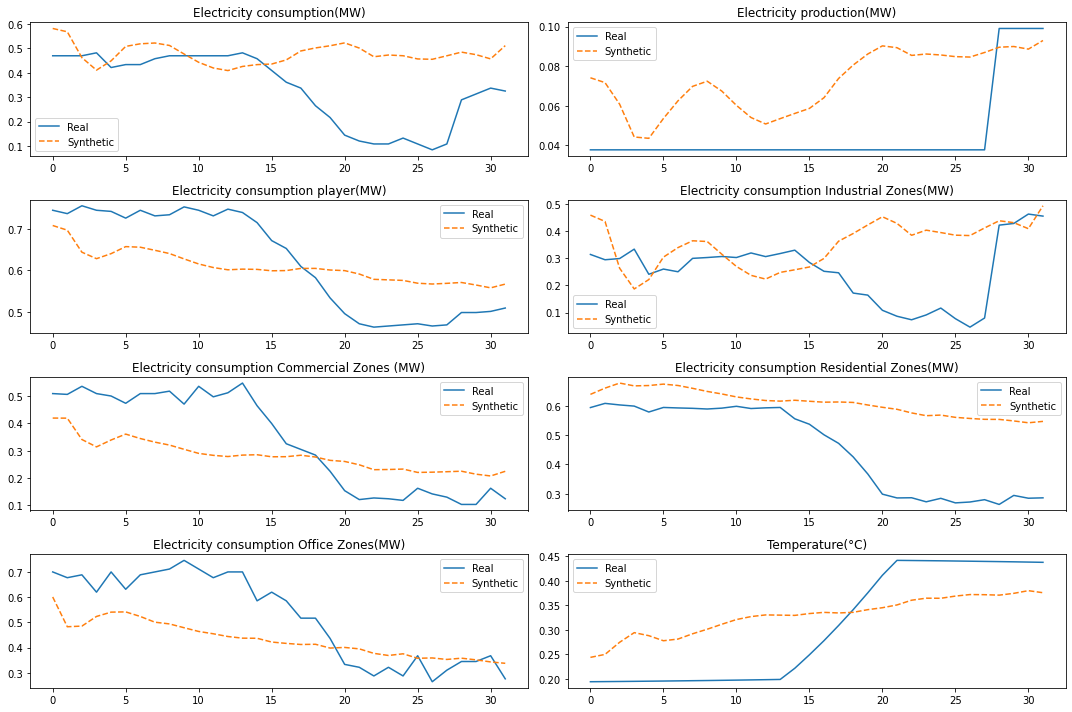

In [11]:
#Reshaping the data
cols = ['Electricity consumption(MW)',
'Electricity production(MW)',
'Electricity consumption player(MW)',
'Electricity consumption Industrial Zones(MW)',
'Electricity consumption Commercial Zones (MW)',
'Electricity consumption Residential Zones(MW)',
'Electricity consumption Office Zones(MW)',
'Temperature(°C)']
#cols = ['Open','High','Low','Close','Adj Close','Volume']
#Plotting some generated samples. Both Synthetic and Original data are still standartized with values between [0,1]
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(15, 10))
axes=axes.flatten()

time = list(range(1,25))
obs = np.random.randint(len(stock_data))

for j, col in enumerate(cols):
    df = pd.DataFrame({'Real': stock_data[obs][:, j],
                   'Synthetic': synth_data[obs][:, j]})
    df.plot(ax=axes[j],
            title = col,
            secondary_y='Synthetic data', style=['-', '--'])
fig.tight_layout()

#### Evaluation of the generated synthetic data (PCA and TSNE)

In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

sample_size = 250
idx = np.random.permutation(len(stock_data))[:sample_size]

real_sample = np.asarray(stock_data)[idx]
synthetic_sample = np.asarray(synth_data)[idx]

#for the purpose of comparision we need the data to be 2-Dimensional. For that reason we are going to use only two componentes for both the PCA and TSNE.
synth_data_reduced = real_sample.reshape(-1, seq_len)
stock_data_reduced = np.asarray(synthetic_sample).reshape(-1,seq_len)

n_components = 2
pca = PCA(n_components=n_components)
tsne = TSNE(n_components=n_components, n_iter=300)

#The fit of the methods must be done only using the real sequential data
pca.fit(stock_data_reduced)

pca_real = pd.DataFrame(pca.transform(stock_data_reduced))
pca_synth = pd.DataFrame(pca.transform(synth_data_reduced))

data_reduced = np.concatenate((stock_data_reduced, synth_data_reduced), axis=0)
tsne_results = pd.DataFrame(tsne.fit_transform(data_reduced))

In [ ]:
#The scatter plots for PCA and TSNE methods
import matplotlib.gridspec as gridspec
fig = plt.figure(constrained_layout=True, figsize=(20,10))
spec = gridspec.GridSpec(ncols=2, nrows=1, figure=fig)

#TSNE scatter plot
ax = fig.add_subplot(spec[0,0])
ax.set_title('PCA results',
             fontsize=20,
             color='red',
             pad=10)

#PCA scatter plot
plt.scatter(pca_real.iloc[:, 0].values, pca_real.iloc[:,1].values,
            c='black', alpha=0.2, label='Original')
plt.scatter(pca_synth.iloc[:,0], pca_synth.iloc[:,1],
            c='red', alpha=0.2, label='Synthetic')
ax.legend()

ax2 = fig.add_subplot(spec[0,1])
ax2.set_title('TSNE results',
              fontsize=20,
              color='red',
              pad=10)

plt.scatter(tsne_results.iloc[:sample_size, 0].values, tsne_results.iloc[:sample_size,1].values,
            c='black', alpha=0.2, label='Original')
plt.scatter(tsne_results.iloc[sample_size:,0], tsne_results.iloc[sample_size:,1],
            c='red', alpha=0.2, label='Synthetic')

ax2.legend()

fig.suptitle('Validating synthetic vs real data diversity and distributions',
             fontsize=16,
             color='grey')

#### Train synthetic test real (TSTR)

In [8]:
from tensorflow.keras import Input, Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import GRU, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanAbsoluteError

#First implement a simple RNN model for prediction
def RNN_regression(units):
    opt = Adam(name='AdamOpt')
    loss = MeanAbsoluteError(name='MAE')
    model = Sequential()
    model.add(GRU(units=units,
                  name=f'RNN_1'))
    model.add(Dense(units=8,
                    activation='sigmoid',
                    name='OUT'))
    model.compile(optimizer=opt, loss=loss)
    return model

In [12]:
#Prepare the dataset for the regression model
stock_data=np.asarray(stock_data)
synth_data = synth_data[:len(stock_data)]
n_events = len(stock_data)

#Split data on train and test
idx = np.arange(n_events)
n_train = int(.75*n_events)
train_idx = idx[:n_train]
test_idx = idx[n_train:]

#Define the X for synthetic and real data
X_stock_train = stock_data[train_idx, :seq_len-1, :]
X_synth_train = synth_data[train_idx, :seq_len-1, :]

X_stock_test = stock_data[test_idx, :seq_len-1, :]
y_stock_test = stock_data[test_idx, -1, :]

#Define the y for synthetic and real datasets
y_stock_train = stock_data[train_idx, -1, :]
y_synth_train = synth_data[train_idx, -1, :]

print('Synthetic X train: {}'.format(X_synth_train.shape))
print('Real X train: {}'.format(X_stock_train.shape))

print('Synthetic y train: {}'.format(y_synth_train.shape))
print('Real y train: {}'.format(y_stock_train.shape))

print('Real X test: {}'.format(X_stock_test.shape))
print('Real y test: {}'.format(y_stock_test.shape))

Synthetic X train: (1764, 31, 8)
Real X train: (1764, 31, 8)
Synthetic y train: (1764, 8)
Real y train: (1764, 8)
Real X test: (589, 31, 8)
Real y test: (589, 8)


In [13]:
#Training the model with the real train data
ts_real = RNN_regression(12)
early_stopping = EarlyStopping(monitor='val_loss')

real_train = ts_real.fit(x=X_stock_train,
                          y=y_stock_train,
                          validation_data=(X_stock_test, y_stock_test),
                          epochs=100,
                          batch_size=128,
                          callbacks=[early_stopping])

Epoch 1/100
14/14 [==============================] - 1s 27ms/step - loss: 0.2061 - val_loss: 0.1957
Epoch 2/100
14/14 [==============================] - 0s 10ms/step - loss: 0.1913 - val_loss: 0.1850
Epoch 3/100
14/14 [==============================] - 0s 10ms/step - loss: 0.1820 - val_loss: 0.1743
Epoch 4/100
14/14 [==============================] - 0s 10ms/step - loss: 0.1712 - val_loss: 0.1632
Epoch 5/100
14/14 [==============================] - 0s 9ms/step - loss: 0.1618 - val_loss: 0.1512
Epoch 6/100
14/14 [==============================] - 0s 9ms/step - loss: 0.1476 - val_loss: 0.1387
Epoch 7/100
14/14 [==============================] - 0s 9ms/step - loss: 0.1366 - val_loss: 0.1285
Epoch 8/100
14/14 [==============================] - 0s 9ms/step - loss: 0.1252 - val_loss: 0.1190
Epoch 9/100
14/14 [==============================] - 0s 9ms/step - loss: 0.1172 - val_loss: 0.1105
Epoch 10/100
14/14 [==============================] - 0s 9ms/step - loss: 0.1097 - val_loss: 0.1031
Epoch

In [14]:
#Training the model with the synthetic data
ts_synth = RNN_regression(12)
synth_train = ts_synth.fit(x=X_synth_train,
                          y=y_synth_train,
                          validation_data=(X_stock_test, y_stock_test),
                          epochs=100,
                          batch_size=128,
                          callbacks=[early_stopping])

Epoch 1/100
14/14 [==============================] - 1s 24ms/step - loss: 0.2286 - val_loss: 0.2175
Epoch 2/100
14/14 [==============================] - 0s 10ms/step - loss: 0.2115 - val_loss: 0.2018
Epoch 3/100
14/14 [==============================] - 0s 9ms/step - loss: 0.1957 - val_loss: 0.1884
Epoch 4/100
14/14 [==============================] - 0s 9ms/step - loss: 0.1815 - val_loss: 0.1767
Epoch 5/100
14/14 [==============================] - 0s 9ms/step - loss: 0.1735 - val_loss: 0.1664
Epoch 6/100
14/14 [==============================] - 0s 16ms/step - loss: 0.1591 - val_loss: 0.1572
Epoch 7/100
14/14 [==============================] - 0s 10ms/step - loss: 0.1501 - val_loss: 0.1486
Epoch 8/100
14/14 [==============================] - 0s 10ms/step - loss: 0.1406 - val_loss: 0.1402
Epoch 9/100
14/14 [==============================] - 0s 10ms/step - loss: 0.1328 - val_loss: 0.1318
Epoch 10/100
14/14 [==============================] - 0s 10ms/step - loss: 0.1230 - val_loss: 0.1228
Ep

In [15]:
#Summarize the metrics here as a pandas dataframe
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_log_error
real_predictions = ts_real.predict(X_stock_test)
synth_predictions = ts_synth.predict(X_stock_test)

metrics_dict = {'r2': [r2_score(y_stock_test, real_predictions),
                       r2_score(y_stock_test, synth_predictions)],
                'MAE': [mean_absolute_error(y_stock_test, real_predictions),
                        mean_absolute_error(y_stock_test, synth_predictions)],
                'MRLE': [mean_squared_log_error(y_stock_test, real_predictions),
                         mean_squared_log_error(y_stock_test, synth_predictions)]}

results = pd.DataFrame(metrics_dict, index=['Real', 'Synthetic'])

results

,r2,MAE,MRLE
Real,0.936858,0.031658,0.001486
Synthetic,0.900679,0.045161,0.002191


In [ ]:
def plot_results(predicted_data, true_data): 
    fig = plt.figure(facecolor='white') 
    ax = fig.add_subplot(111) 
    ax.plot(true_data, label='True Data') 
    plt.plot(predicted_data, label='Prediction') 
    plt.legend() 
    plt.show() 

In [ ]:
from numpy import newaxis

def predict_sequence_full(model, data, window_size):
    #Shift the window by 1 new prediction each time, re-run predictions on new window
    curr_frame = data[0]
    predicted = []
    for i in range(len(data)):
        predicted.append(model.predict(curr_frame[newaxis,:,:])[0,0])
        print(f"predicted = {predicted}")
        curr_frame = curr_frame[1:]
        print(f"curr_frame = {curr_frame}")

        curr_frame = np.insert(curr_frame, [window_size-1], predicted[-1], axis=0)
    return predicted

In [43]:
real_predictions = ts_real.predict(X_stock_test[0:1])
real_predictions.shape

(1, 8)

In [41]:
(X_stock_test[0:1]).shape

(1, 31, 8)

In [40]:
scaler.inverse_transform(X_stock_test[0:1][0])[0]

array([161.     ,  85.     ,  15.248  ,  48.208  ,   3.472  ,  91.376  ,
         2.72   ,  21.53829])

In [32]:
scaler.inverse_transform(real_predictions)[0]

array([174.96387  ,  85.253685 ,  17.863604 ,  54.50337  ,   3.9937332,
        97.79009  ,   2.8801463,  17.3693   ], dtype=float32)

In [ ]:
real_predictions[0].shape

In [19]:
X_stock_test.shape

(589, 31, 8)

In [ ]:
y_stock_test.shape

In [ ]:
y_stock_test[0].shape


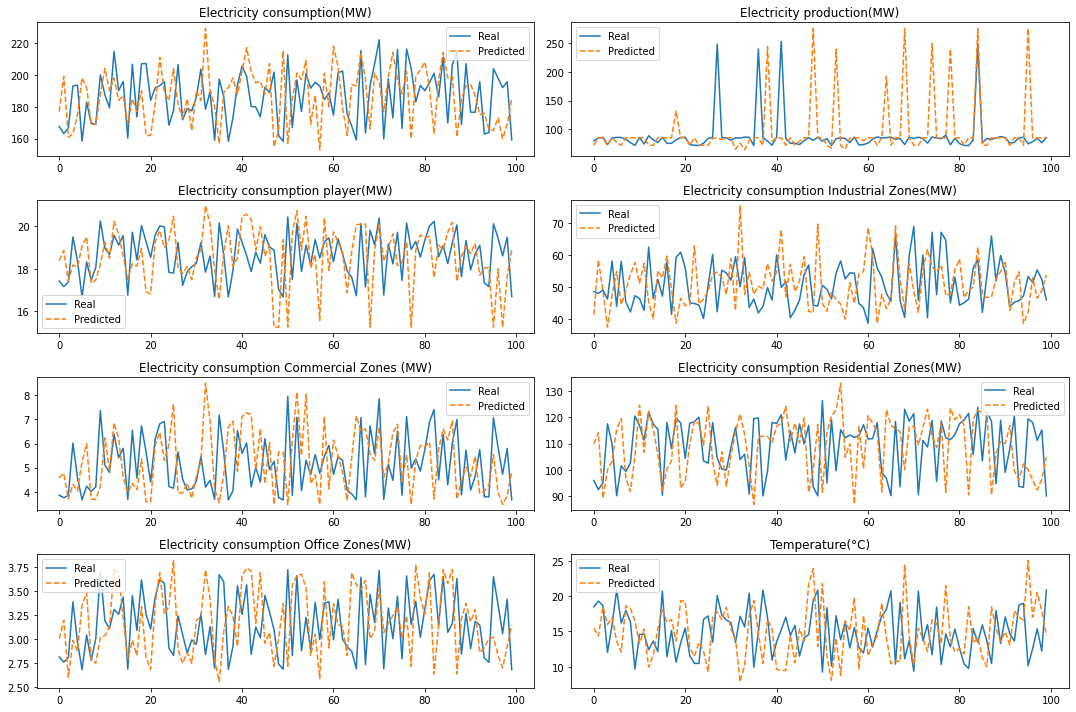

In [25]:


real_predictions2 = scaler.inverse_transform(real_predictions)
y_stock_test2 = scaler.inverse_transform(y_stock_test)

fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(15, 10))
axes=axes.flatten()

time = list(range(1,32))
obs = np.random.randint(len(y_stock_test2))

for j, col in enumerate(cols):
    df = pd.DataFrame({'Real': real_predictions2[:, j],
                   'Predicted': y_stock_test2[200:300, j]})
    df.plot(ax=axes[j],
            title = col, 
            secondary_y='Synthetic data', style=['-', '--'])
fig.tight_layout()

In [ ]:
X_stock_test


In [ ]:
y_stock_test